In [1]:
import torch
import os
import numpy as np
from PIL import Image
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn
from einops.layers.torch import Rearrange
import math
from utils import *
import json
import torch
import open_clip


/home/kyw/miniconda3/envs/BCI_38/lib/python3.8/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/kyw/miniconda3/envs/BCI_38/lib/python3.8/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [ ]:
import torch.nn.functional as F
from torch.utils.data import DataLoader
from diffusion_prior import *
from custom_pipeline import *
import random
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# 加载模型、训练时的预处理和特征提取器
vlmodel, preprocess_train, feature_extractor = open_clip.create_model_and_transforms(
    model_name = 'ViT-H-14', pretrained = None, precision='fp32', device=device
)

# 加载你已经下载的权重文件
model_weights_path = "/mnt/repo0/kyw/open_clip_pytorch_model.bin"
model_state_dict = torch.load(model_weights_path, map_location=device)
vlmodel.load_state_dict(model_state_dict)

# 将模型设置为评估模式
vlmodel.eval()

/tmp/ipykernel_1298269/4249575847.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load(model_weights_path, map_location=device)


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-31): 32 x ResidualAttentionBlock(
          (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1280, out_features=5120, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=5120, out_features=1280, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((1280,), eps=1e-05, elementwi

In [4]:
diffusion_model_path = "/mnt/repo0/kyw/close-loop/sub_model/sub-08/diffusion_250hz/ATM_S_reconstruction_scale_0_1000_40.pth"
checkpoint = torch.load(diffusion_model_path, map_location=device)
eeg_model = ATM_S_reconstruction_scale_0_1000(17, 250)  # 例如 ATM_S_reconstruction_scale_0_1000 是 EEG 模型
img_model = Proj_img()  # 假设使用的是 Proj_img 模型

eeg_model.load_state_dict(checkpoint['eeg_model_state_dict'])
img_model.load_state_dict(checkpoint['img_model_state_dict'])
optimizer_state = checkpoint['optimizer_state_dict']

/tmp/ipykernel_1298269/3269485241.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(diffusion_model_path, map_location=device)
/home/kyw/miniconda3

In [6]:

def get_gteeg(image_gt_path, encoder_model_path, device):
    img_model.eval()

    model = load_model_endocer(encoder_model_path, device)
    image_tensor = preprocess_image(image_gt_path, device)
    synthetic_eeg = generate_eeg(model, image_tensor, device)
    
    # save_eeg_signal(synthetic_eeg, syn_eeg_path, idx=0, category = category)
    return synthetic_eeg

    
def save_eeg(synthetic_eeg, gt_eeg_path, file_name):
# 文件名带有排序特征
    gt_eeg_path = os.path.join(gt_eeg_path, file_name)
    np.save(gt_eeg_path, synthetic_eeg)
    return gt_eeg_path

def load_thingstestimagedata(img_directory):
    images = []
    category_images = []  # 用于存储每个类别的12张图片
    all_folders = [d for d in os.listdir(img_directory) if os.path.isdir(os.path.join(img_directory, d))]
    all_folders.sort()  # 保证文件夹的顺序
    # print(all_folders)
    for folder in all_folders:
        # print(folder)
        folder_path = os.path.join(img_directory, folder)
        folder_images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        folder_images.sort()  # 保证每类图片按顺序
        # print(folder_images)
        
        
        # 只保留前12张图片
        folder_images = folder_images[:12]
        full_image_paths = [os.path.join(folder_path, img) for img in folder_images]
        category_images.append(full_image_paths)
       
    # print(category_images)
    return category_images  # 返回每个类别的图片路径列表

Visualization saved to ./results/Similarity_Plot.png


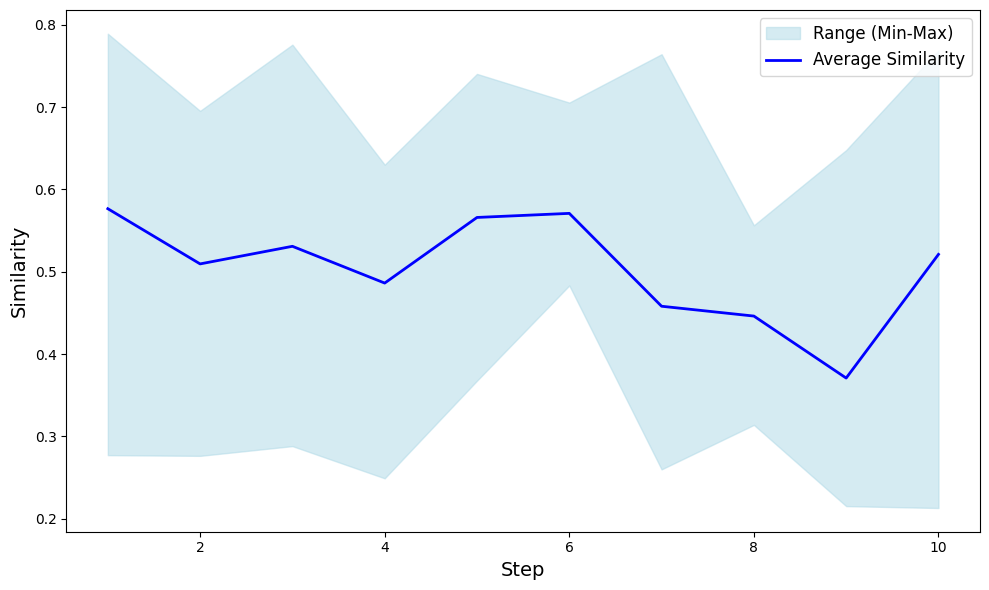

In [82]:
def initial_policy(image_pool, num_images=10, history=None):
    """
    在所有图片中随机选择 num_images 张图片
    :param image_pool: [200, 12, 1024] 的图片池
    :param num_images: 选择的图片数量
    :param history: 历史选择过的图片索引
    :return: 选中的图片的类别和图片索引
    """
    total_images = image_pool.view(-1, 1024)  # 展平到 [2400, 1024]
    if history is None:
        history = []

    # 排除已经选择过的图片
    available_indices = [i for i in range(len(total_images)) if i not in history]
    indices = np.random.choice(available_indices, num_images, replace=False)

    # 将索引转换为类别和图片索引
    category_indices = indices // 12  # 每12张图片为一类
    image_indices = indices % 12  # 类别中的图片索引
    return list(zip(category_indices, image_indices))  # 返回 (类别, 图片) 的索引对

def compute_cosine_similarity(img_feature, all_features):
    """
    计算某张图片与所有其他图片的余弦相似度
    :param img_feature: 选中图片的特征向量 [1024]
    :param all_features: 所有图片的特征向量 [2400, 1024]
    :return: 余弦相似度 [2400]
    """
    # 计算余弦相似度
    # distances = torch.norm(all_features - img_feature, dim=1)
    # cos_sim = torch.nn.functional.cosine_similarity(img_feature, all_features, dim=1)
    # # cos_sim = F.softmax(cos_sim, dim=0)
    dot_product = torch.matmul(all_features, img_feature)
    # cos_sim = (cos_sim + 1) / 2
    return dot_product



def reward_function(image_path, encoder_model_path, yhat,  timestamp):
    """
    生成与某张图片对应的脑电信号，并与 groundtruth 进行相似度计算
    :param image: 图片特征向量 [1024]
    :param groundtruth_eeg: groundtruth 的特征向量 [1024]
    :return: EEG信号与groundtruth的相似度
    """
    # 模拟生成的 EEG 信号，实际应替换为 EEG 模型输出
    syn_eeg_folder = f'/mnt/repo0/kyw/close-loop/results/syn_eeg'
    eeg_signal = torch.tensor(get_gteeg(image_path, encoder_model_path, device))
    syn_eeg_path = save_eeg(eeg_signal, syn_eeg_folder,file_name=f"gt_{timestamp}.npy" )
    
    eeg_feature = get_eeg_features(eeg_model, eeg_signal, device)
    # print(eeg_feature.shape)
    # print(yhat.shape)
    # distance = torch.sqrt(torch.sum((eeg_feature - yhat) ** 2))
    # eeg_feature= eeg_feature.squeeze()
    # yhat = yhat.squeeze()
    # print(eeg_feature.shape)
    # print(yhat.shape)
    # similarity = torch.dot(eeg_feature,yhat)
    similarity = torch.nn.functional.cosine_similarity(eeg_feature, yhat)
    # cos_sim = F.softmax(cos_sim)
    similarity = (similarity + 1) / 2
    
    print(similarity)
    return similarity.item(),eeg_feature

# 策略评估：计算每个状态的价值
def policy_evaluation(policy, image_pool,  best_images, similarities,encoder_model_path, timestamp, text_list,value_function, historical_max_similarity,gamma, history=None):
    """
    评估当前策略的价值
    :param policy: 当前策略，用来选择图片
    :param image_pool: 图片特征池 [200, 12, 1024]
    :param groundtruth_eeg: groundtruth 脑电特征向量 [1024]
    :param gamma: 折扣因子
    :param history: 选择过的图片的历史记录
    :return: 每个图片的价值 [2400]
    """


    # value_function = np.zeros(len(image_pool))  # 初始化价值函数
    # selected_images = policy(image_pool, history=history)  # 根据策略选择图片
    # print(selected_images)
    all_similarities_imgs = []
    similarities_imgs = []
    selected_image_paths = []
    # print("jjjjjjjj")
    print(best_images)
    for rank, ((cat, idx), similarity) in enumerate(zip(best_images, similarities)):
        # 获取选中图片的特征
        img_feature = image_pool[cat * 12 + idx]
        # cosine_similarities = compute_cosine_similarity(img_feature, image_pool)
        euclidean_similarities = compute_cosine_similarity(img_feature, image_pool)
        print('dddddd')
        print(euclidean_similarities)
        print(euclidean_similarities.shape)
        sssss, _ = torch.sort(euclidean_similarities)
        max_value = torch.max(euclidean_similarities)
        min_value = torch.min(euclidean_similarities)
        print(max_value)
        print(min_value)
        print(sssss[1])
        euclidean_distances_array = euclidean_similarities.cpu().numpy()  # Convert tensor to numpy array

        # Save as txt
        np.savetxt('euclidean_distances.txt', euclidean_distances_array)
        if rank == 0:
            if similarity > historical_max_similarity:
                rank_reward = 2*(1+similarity) # 奖励倍增
            else:
                rank_reward = similarity+1
        # if distance > 8.0:  # 对于相似度低于某个阈值的图片，给予负奖励
            # rank_reward = -abs(1 / (1 + distance)) * (1 + 0.1 * rank)  # 负奖励：根据排名递增
        # else:
        if similarity > 0.8:
            rank_reward = (1+similarity) * (1 - 0.1 * rank)  # 正奖励，随着排名递减
            value_function[cat * 12 + idx] += rank_reward  # 更新选中图片的价值
            h=0
            for i in range(len(image_pool.view(-1, 1024))):  # 遍历所有图片
            
                similarity_weight = euclidean_similarities[i].item()
                # print(similarity_weight)
                # reward_to_spread = gamma  *(1 / (1 + euclidean_distances[i].item()))
            
                if euclidean_similarities[i] > 0.6:
                    h +=1
                
                
                    reward_to_spread = gamma  *  euclidean_similarities[i].item()
                    value_function[i] += reward_to_spread * rank_reward
                    x= reward_to_spread * rank_reward
                    print(x)
            print('jhhhhh')
            
            print(h)
                
            
            
            
        


    return value_function


# 策略改进：根据价值函数调整策略
def policy_improvement(value_function, image_pool, iteration=None, save_folder=None,num_images=10, temperature=1.0):
    """
    根据当前价值函数改进策略
    :param value_function: 价值函数
    :param image_pool: 图片特征池 [200, 12, 1024]
    :param num_images: 每轮选择的图片数量
    :return: 改进后的策略函数
    """
    from scipy.special import softmax
    def improved_policy(image_pool, history= None):
        # total_images = image_pool.view(-1, 1024)  # 展平到 [2400, 1024]
        
        # 排除历史中已经选择过的图片
        if history:
            available_indices = [i for i in range(len(image_pool)) if i not in history]
        else:
            available_indices = np.arange(len(image_pool))
        
        # print('ceshi')    
        # print(available_indices[2399])
        
        scaled_values = value_function[available_indices] / temperature
        
        # 基于价值函数为每张图片分配概率
        # 使用 softmax 将价值转化为概率，这样价值高的图片有更大概率被选中
        value_probs = softmax(scaled_values)

        
        
        # 打印或保存每轮迭代中的权重
        if iteration is not None and save_folder is not None:
            weight_save_path = os.path.join(save_folder, f"weights_iteration_{iteration}.txt")
            with open(weight_save_path, "w") as f:
                for idx, prob in zip(available_indices, value_probs):
                    f.write(f"Image index: {idx}, Probability: {prob}\n")
            print(f"Saved weights for iteration {iteration} at {weight_save_path}")

        # 根据分配的概率选择图片
        best_images = np.random.choice(available_indices, size=num_images, p=value_probs, replace=False)
        category_indices = best_images // 12  # 每12张图片为一类
        image_indices = best_images % 12  # 类别中的图片索引
        print(best_images)
        print(category_indices)
        print(image_indices)

        return list(zip(category_indices, image_indices))
    
    return improved_policy


def get_image_path(category_idx, image_idx, text_list):
    """
    根据类别和图片索引返回图片路径，检查文件夹是否包含12张图片
    :param category_idx: 类别索引
    :param image_idx: 图片索引
    :param text_list: 文件夹列表
    :return: 图片的路径
    """
    # 获取类别文件夹路径

    category_folder = text_list[category_idx]
    print(category_idx)
    print(category_folder)
    folder_path = f"/mnt/repo0/kyw/images_set/full_test_images/{category_folder}"
    
    image_file = [f for f in sorted(os.listdir(folder_path)) if f.endswith(('.jpg', '.png')) and not f.startswith('._')]
    
    # print(image_file)
        # # 检查文件夹中的图片数量是否为12
    # images_in_folder = sorted(os.listdir(folder_path))
    
    
    # if len(images_in_folder) != 12:
    #     raise ValueError(f"Error: The folder {folder_path} contains {len(images_in_folder)} images, but 12 are expected.")
    
    # # 获取图片文件名，假设文件夹中的图片按某种顺序排列
    image_file = image_file[image_idx]
    
    # 返回图片的完整路径
    return os.path.join(folder_path, image_file)

def save_amx_similarities(folder_path, loooop_max_similarities):
    """
    保存每一轮迭代的图片、相似度和方差
    :param folder_path: 保存的根文件夹
    :param iteration: 当前迭代轮次
    :param image_paths: 图片路径列表
    :param similarities: 相似度列表
    :param variance: 相似度的方差
    """
    iter_folder = os.path.join(folder_path)
    os.makedirs(iter_folder, exist_ok=True)
    
    # # 保存图片
    # for i, image_path in enumerate(image_paths):
    #     image = Image.open(image_path)
    #     image.save(os.path.join(iter_folder, f"selected_image_{i}.jpg"))
    
    # 保存相似度和方差
    with open(os.path.join(iter_folder, "similarities.txt"), "w") as f:
        f.write(f"MAx similarity: {loooop_max_similarities}\n")
        # # f.write(f"Variance: {variance}\n")
        # f.write(f"Similarities: {similarities}\n")

def save_results(folder_path, iteration, image_paths,  similarities, max_similarity):
    """
    保存每一轮迭代的图片、相似度和方差
    :param folder_path: 保存的根文件夹
    :param iteration: 当前迭代轮次
    :param image_paths: 图片路径列表
    :param similarities: 相似度列表
    :param variance: 相似度的方差
    """
    iter_folder = os.path.join(folder_path, f"iteration_{iteration}")
    os.makedirs(iter_folder, exist_ok=True)
    
    # 保存图片
    for i, image_path in enumerate(image_paths):
        image = Image.open(image_path)
        image.save(os.path.join(iter_folder, f"selected_image_{i}.jpg"))
    
    # 保存相似度和方差
    with open(os.path.join(iter_folder, "similarities.txt"), "w") as f:
        f.write(f"MAx similarity: {max_similarity}\n")
        # f.write(f"Variance: {variance}\n")
        f.write(f"Similarities: {similarities}\n")
        
def visualize_images(image_paths, similarities, save_folder,iteration):
    """
    使用 matplotlib 按相似度顺序显示选中的图片
    :param image_paths: 图片路径列表
    :param similarities: 每张图片的相似度列表
    """
    # 将图片路径和相似度结合，并按相似度降序排序
    image_similarity_pairs = sorted(zip(image_paths, similarities), key=lambda x: x[1], reverse=True)
    
    # 拆分排序后的图片路径和相似度
    sorted_image_paths, sorted_similarities = zip(*image_similarity_pairs)

    # 绘制图像
    fig, axes = plt.subplots(1, len(sorted_image_paths), figsize=(15, 5))
    for i, image_path in enumerate(sorted_image_paths):
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f'Distance: {sorted_similarities[i]:.4f}', fontsize=8)  # 显示相似度
    plt.show()
    
    os.makedirs(save_folder, exist_ok=True)  # 创建文件夹（如果不存在）
    save_path = os.path.join(save_folder, f"visualization_iteration_{iteration}.png")
    fig.savefig(save_path, bbox_inches='tight')  # 保存图像文件
    print(f"Visualization saved to {save_path}")


import os
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt


def plot_similarity_and_mse_with_dual_axis(similarities_per_iteration, save_folder, target_similarity=1.0):
    """
    绘制相似度和根据相似度计算的MSE曲线，带误差带，使用双坐标轴，并调整外框线宽。
    :param similarities_per_iteration: 每轮迭代中的相似度列表，形状为 [iterations, num_images_per_iteration]
    :param save_folder: 保存图片的文件夹
    :param target_similarity: 目标相似度，用于计算MSE，默认为1.0（表示完全相似）
    """
    plt.figure(figsize=(10, 6))

    num_iterations = len(similarities_per_iteration)  # 迭代次数
    iterations = range(1, num_iterations + 1)

    # 计算每轮的平均相似度、最大相似度和最小相似度
    avg_similarities = [np.mean(similarities) for similarities in similarities_per_iteration]
    max_similarities = [np.max(similarities) for similarities in similarities_per_iteration]
    min_similarities = [np.min(similarities) for similarities in similarities_per_iteration]

    # 只基于 max_similarities 计算每轮迭代的 MSE
    mse_per_iteration = [(sim - target_similarity)**2 for sim in max_similarities]

    # 创建双坐标轴
    fig, ax1 = plt.subplots(figsize=(8, 6))

    # 绘制误差带 (极差误差带) 在左边的坐标轴
    ax1.fill_between(iterations, min_similarities, max_similarities, color='lightblue', alpha=0.5, label='Range (Min-Max)')
    ax1.plot(iterations, avg_similarities, color='blue', label='Average Similarity', linewidth=2)
    ax1.set_xlabel('Step', fontsize=14)
    ax1.set_ylabel('Similarity', fontsize=14)
    ax1.spines['top'].set_visible(False)  # 去除顶部的线

    # 设置边框的线条宽度
    # ax1.spines['top'].set_linewidth(0.8)  # 顶部边框
    ax2 = ax1.twinx()
    ax2.plot(range(1, 11), mse_per_iteration, color='orange', label='MSE', linewidth=2)
    ax2.set_ylabel('MSE', fontsize=14)
    ax2.spines['top'].set_visible(False)  # 去除顶部的线
    # ax1.spines['right'].set_linewidth(0.8)  # 右边框
    # ax1.spines['left'].set_linewidth(0.8)  # 左边框
    # ax1.spines['bottom'].set_linewidth(0.8)  # 底部边框
    # 调整图例位置，缩小占据空间
    ax1.legend(loc='upper left', fontsize=10)
    ax2.legend(loc='upper right', fontsize=10)

    # 显示图形
    plt.tight_layout()
    plt.show()
    # 创建右边的坐标轴，用于绘制MSE曲线
    # ax2 = ax1.twinx()
    # ax2.plot(iterations, mse_per_iteration, color='orange', label='MSE', linewidth=2)
    # ax2.set_ylabel('MSE', fontsize=14)
    # ax2.legend(loc='upper right', fontsize=12)

    # # 设置右侧边框的线条宽度
    # ax2.spines['top'].set_linewidth(0.8)
    # ax2.spines['right'].set_linewidth(0.8)
    # ax2.spines['left'].set_linewidth(0.8)
    # ax2.spines['bottom'].set_linewidth(0.8)

    # # 显示图形
    # plt.tight_layout()

    # 保存图像
    save_path = os.path.join(save_folder, f"Similarity_and_MSE_with_Dual_Axis_Plot.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=300)  # 保存图像文件为高清
    print(f"Visualization saved to {save_path}")
    
    # 显示图形并关闭
    plt.show()
    plt.close()


# def plot_similarity_and_mse_with_dual_axis(similarities_per_iteration, save_folder, target_similarity=1.0):
#     """
#     绘制相似度和根据相似度计算的MSE曲线，带误差带，使用双坐标轴。
#     :param similarities_per_iteration: 每轮迭代中的相似度列表，形状为 [iterations, num_images_per_iteration]
#     :param save_folder: 保存图片的文件夹
#     :param target_similarity: 目标相似度，用于计算MSE，默认为1.0（表示完全相似）
#     """
#     plt.figure(figsize=(10, 6))

#     num_iterations = len(similarities_per_iteration)  # 迭代次数
#     iterations = range(1, num_iterations + 1)

#     # 计算每轮的平均相似度、最大相似度和最小相似度
#     avg_similarities = [np.mean(similarities) for similarities in similarities_per_iteration]
#     max_similarities = [np.max(similarities) for similarities in similarities_per_iteration]
#     min_similarities = [np.min(similarities) for similarities in similarities_per_iteration]

#     # 只基于 max_similarities 计算每轮迭代的 MSE
#     mse_per_iteration = [(sim - target_similarity)**2 for sim in max_similarities]

#     # 创建双坐标轴
#     fig, ax1 = plt.subplots()

#     # 绘制误差带 (极差误差带) 在左边的坐标轴
#     ax1.fill_between(iterations, min_similarities, max_similarities, color='lightblue', alpha=0.5, label='Range (Min-Max)')
#     ax1.plot(iterations, avg_similarities, color='blue', label='Average Similarity', linewidth=2)
#     ax1.set_xlabel('Iteration', fontsize=14)
#     ax1.set_ylabel('Similarity', fontsize=14)
#     ax1.legend(loc='upper left', fontsize=12)

#     # 创建右边的坐标轴，用于绘制MSE曲线
#     ax2 = ax1.twinx()
#     ax2.plot(iterations, mse_per_iteration, color='orange', label='MSE', linewidth=2)
#     ax2.set_ylabel('MSE', fontsize=14)
#     ax2.legend(loc='upper right', fontsize=12)

#     # 显示图形
#     plt.tight_layout()

#     # 保存图像
#     save_path = os.path.join(save_folder, f"Similarity_and_MSE_with_Dual_Axis_Plot.png")
#     plt.savefig(save_path, bbox_inches='tight', dpi=300)  # 保存图像文件为高清
#     print(f"Visualization saved to {save_path}")
    
#     # 显示图形并关闭
#     plt.show()
#     plt.close()  # 关闭图形，释放内存
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_similarity_range(similarities_per_iteration, save_folder):
    """
    绘制每轮迭代中的相似度范围图。
    :param similarities_per_iteration: 每轮迭代中的相似度列表，形状为 [iterations, num_images_per_iteration]
    :param save_folder: 保存图片的文件夹
    """
    plt.figure(figsize=(10, 6))

    num_iterations = len(similarities_per_iteration)  # 迭代次数
    iterations = range(1, num_iterations + 1)

    # 计算每轮的平均相似度、最大相似度和最小相似度
    avg_similarities = [np.mean(similarities) for similarities in similarities_per_iteration]
    max_similarities = [np.max(similarities) for similarities in similarities_per_iteration]
    min_similarities = [np.min(similarities) for similarities in similarities_per_iteration]

    # 绘制误差带 (极差误差带)
    plt.fill_between(iterations, min_similarities, max_similarities, color='lightblue', alpha=0.5, label='Range (Min-Max)')

    # 绘制相似度均值连线
    plt.plot(iterations, avg_similarities, color='blue', label='Average Similarity', linewidth=2)

    # 设置边框的线条宽度
    plt.gca().spines['top'].set_linewidth(0.8)  # 顶部边框
    plt.gca().spines['right'].set_linewidth(0.8)  # 右边框
    plt.gca().spines['left'].set_linewidth(0.8)  # 左边框
    plt.gca().spines['bottom'].set_linewidth(0.8)  # 底部边框

    # 设置标签和图例
    plt.xlabel('Step', fontsize=14)
    plt.ylabel('Similarity', fontsize=14)
    plt.legend(loc='upper right', fontsize=12)

    # 显示图形并保存
    plt.tight_layout()

    save_path = os.path.join(save_folder, "Similarity_Plot.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=300)  # 保存图像文件为高清
    print(f"Visualization saved to {save_path}")

    # 显示图形并关闭
    plt.show()
    plt.close()

# 示例数据与调用:
similarities_per_iteration = [np.random.uniform(0.2, 0.8, 5) for _ in range(10)]
save_folder = './results'
os.makedirs(save_folder, exist_ok=True)

plot_similarity_range(similarities_per_iteration, save_folder)








# def plot_similarity_range(max_similarities, min_similarities, variances, save_folder):
#     plt.figure(figsize=(10, 6))

#     iterations = range(1, len(max_similarities) + 1)
#     print(max_similarities)

#     # 绘制相似度范围（灰色区域）
#     plt.fill_between(iterations, min_similarities, max_similarities, color='lightgray', alpha=0.5, label='Distance Range')

#     # 绘制最小距离连线
#     # plt.plot(iterations, min_distances, marker='o', color='red', label='Min Distance', linewidth=2)

#     # 绘制最大距离连线
#     plt.plot(iterations, max_similarities, marker='o', color='red', label='Max Similarity', linewidth=2)

#     # 增加网格线
#     # plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

#     # 设置y轴范围（根据你的距离范围0-15）
#     # plt.ylim(0, 10)

#     # 设置标题和轴标签，并调整字体大小
#     # plt.title('Similarity Range and Max Similarity', fontsize=16)
#     plt.xlabel('Iteration', fontsize=14)
#     plt.ylabel('Similarity', fontsize=14)

#     # 调整图例位置
#     plt.legend(loc='lower right', fontsize=12)

#     # 显示图形
#     plt.tight_layout()

#     # 保存图像
#     save_path = os.path.join(save_folder, f"Similarity_Plot.png")
#     plt.savefig(save_path, bbox_inches='tight', dpi=300)  # 保存图像文件为高清
#     print(f"Visualization saved to {save_path}")
    
#     # 显示图形并关闭
#     plt.show()
#     plt.close()  # 关闭图形，释放内存
    
    




def visualize_feature_distribution(yhat, selected_eegs_per_iteration, save_folder):
    """
    可视化EEG特征分布，随着迭代展示10个EEG相对于目标的位置，颜色随着迭代变深，且标记每次迭代最接近目标的点。
    :param yhat: 目标EEG特征向量，形状为 [1, 1024]
    :param selected_eegs_per_iteration: 每次迭代选择的EEG特征，形状为 [iterations, 10, 1, 1024]
    :param save_folder: 图像保存的文件夹
    """

    # 将目标 EEG 特征从 [1, 1024] 转换为 [1024]，并移除梯度追踪
    yhat = yhat.squeeze().detach()
    # plt.xlabel('t-SNE dimension 2', fontsize=14)
    # plt.ylabel('t-SNE dimension 1', fontsize=14)

    # 将目标 EEG 特征和每轮选中的 EEG 特征合并，用于 PCA 降维
    all_eegs = np.vstack([yhat.cpu().numpy()] + 
                         [np.array([feature.squeeze().detach().cpu().numpy() for feature in features]) 
                          for features in selected_eegs_per_iteration])

    # 使用 PCA 将 EEG 特征降维到 2D
    pca = PCA(n_components=2)
    all_eegs_2d = pca.fit_transform(all_eegs)

    # 获取降维后的目标 EEG 特征
    target_feature_2d = all_eegs_2d[0]

    # 获取每次迭代中选择的 EEG 特征（已降维）
    start_idx = 1
    selected_eegs_2d_per_iteration = []
    for i in range(len(selected_eegs_per_iteration)):
        end_idx = start_idx + len(selected_eegs_per_iteration[i])
        selected_eegs_2d_per_iteration.append(all_eegs_2d[start_idx:end_idx])
        start_idx = end_idx

    plt.figure(figsize=(10, 8))

    # 使用 'viridis' 连续调色板，并反转颜色，颜色跨度更大
    cmap = plt.cm.get_cmap('viridis', len(selected_eegs_per_iteration)).reversed()  # 生成 len(selected_eegs_per_iteration) 个不同颜色
    iterations = len(selected_eegs_per_iteration)

    # 绘制每轮选中的EEG
    for i in range(iterations):
        selected_features_2d = selected_eegs_2d_per_iteration[i]
        
        # 计算每个点到目标的欧几里得距离
        distances = np.linalg.norm(selected_features_2d - target_feature_2d, axis=1)
        
        # 将距离归一化为 0 到 1 之间
        norm_distances = (distances - distances.min()) / (distances.max() - distances.min() + 1e-6)

        # 获取当前迭代的颜色
        base_color = cmap(i / iterations)

        # 找到每轮中距离最近的点
        closest_idx = np.argmin(distances)
        
        # 绘制每轮中9个点（半透明，点越远越小）
        for j in range(len(selected_features_2d)):
            if j != closest_idx:  # 不绘制最近的点
                size = 50 * (1 - norm_distances[j]) + 20  # 根据距离调整大小
                alpha = 0.3  # 半透明
                plt.scatter(selected_features_2d[j, 0], selected_features_2d[j, 1], color=base_color, s=size, alpha=alpha)
        
        # 绘制每轮中距离最近的点（正常颜色，正常大小）
        plt.scatter(selected_features_2d[closest_idx, 0], selected_features_2d[closest_idx, 1], color=base_color, s=150, alpha=1.0, label=f'Iteration {i+1}')
    
    # 确保目标点在最上层，且不被覆盖
    plt.scatter(target_feature_2d[0], target_feature_2d[1], color='red', label='Target', s=300, marker='*', zorder=5)

    # 增加网格线
    # plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # 设置标题和轴标签
    # plt.title('EEG Feature Distribution Over Iterations', fontsize=16)
    plt.xlabel('t-SNE dimenstion2', fontsize=14)
    plt.ylabel('t-SNE dimenstion1', fontsize=14)

    # 调整图例，右侧只显示迭代次数
    plt.legend(loc='upper left', fontsize=12, bbox_to_anchor=(1.05, 1), borderaxespad=0.)

    # 保存图像
    save_path = os.path.join(save_folder, f"EEG_Feature_Distribution_Over_Iterations.png")
    plt.savefig(save_path,  dpi=300)  # 保存图像文件为高清
    print(f"Visualization saved to {save_path}")
    
    # 显示图形并关闭
    plt.show()
    plt.close()  # 关闭图形，释放内存


    


def save_value_function_to_txt(value_function, save_folder,iteration):
    """
    将 value_function 保存为一个 .txt 文件，每行保存 12 个值
    :param value_function: 要保存的值 (PyTorch 张量或 NumPy 数组)
    :param save_folder: 保存文件的文件夹路径
    """
    # 如果 value_function 是 PyTorch 张量，先转换为 NumPy 数组
    if isinstance(value_function, torch.Tensor):
        value_function = value_function.cpu().numpy()

    # 构建保存路径
    save_path = os.path.join(save_folder, f'value_function_scores_{iteration}.txt')

    # 将数值按行（每行 12 个）写入 .txt 文件
    with open(save_path, 'w') as f:
        for i in range(0, len(value_function), 12):
            line_values = value_function[i:i + 12]
            line_str = " ".join(map(str, line_values))  # 用空格分隔每个值
            f.write(f"{line_str}\n")  # 每行写 12 个值
    
    print(f"value_function saved to {save_path}")


def set_random_seed(seed):
    """
    设置随机种子以确保实验的可重复性
    :param seed: 要使用的随机种子
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 如果使用GPU
    torch.backends.cudnn.deterministic = True  # 保证每次运行时卷积算法的确定性
    torch.backends.cudnn.benchmark = False  # 保证与随机性无关的优化




In [ ]:
import torch
import os
from PIL import Image
import open_clip
from tqdm import tqdm  # 导入 tqdm



In [8]:

image_gt_folder = [
'/mnt/repo0/ldy/3090/Workspace/THINGS/osfstorage/THINGS/Images/images/pheasant/pheasant_18s.jpg',
'/mnt/repo0/ldy/3090/Workspace/THINGS/osfstorage/THINGS/Images/images/pheasant/pheasant_03s.jpg',
'/mnt/repo0/ldy/3090/Workspace/THINGS/osfstorage/THINGS/Images/images/aircraft_carrier/aircraft_carrier_09s.jpg',
'/mnt/repo0/ldy/3090/Workspace/THINGS/osfstorage/THINGS/Images/images/banana/banana_04s.jpg',
'/mnt/repo0/ldy/3090/Workspace/THINGS/osfstorage/THINGS/Images/images/basil/basil_07s.jpg',
'/mnt/repo0/ldy/3090/Workspace/THINGS/osfstorage/THINGS/Images/images/basketball/basketball_13s.jpg',
'/mnt/repo0/ldy/3090/Workspace/THINGS/osfstorage/THINGS/Images/images/bench/bench_01b.jpg',
'/mnt/repo0/ldy/3090/Workspace/THINGS/osfstorage/THINGS/Images/images/bench/bench_05s.jpg',
'/mnt/repo0/ldy/3090/Workspace/THINGS/osfstorage/THINGS/Images/images/bike/bike_15s.jpg',
'/mnt/repo0/ldy/3090/Workspace/THINGS/osfstorage/THINGS/Images/images/birthday_cake/birthday_cake_15s.jpg',
'/mnt/repo0/ldy/3090/Workspace/THINGS/osfstorage/THINGS/Images/images/brace/brace_04s.jpg',
'/mnt/repo0/ldy/3090/Workspace/THINGS/osfstorage/THINGS/Images/images/boat/boat_10s.jpg',
'/mnt/repo0/ldy/3090/Workspace/THINGS/osfstorage/THINGS/Images/images/cheetah/cheetah_10s.jpg',
'/mnt/repo0/ldy/3090/Workspace/THINGS/osfstorage/THINGS/Images/images/coconut/coconut_19s.jpg',
'/mnt/repo0/ldy/3090/Workspace/THINGS/osfstorage/THINGS/Images/images/folder/folder_03s.jpg',
'/mnt/repo0/ldy/3090/Workspace/THINGS/osfstorage/THINGS/Images/images/glove/glove_12s.jpg',
'/mnt/repo0/ldy/3090/Workspace/THINGS/osfstorage/THINGS/Images/images/goose/goose_03s.jpg',
'/mnt/repo0/ldy/3090/Workspace/THINGS/osfstorage/THINGS/Images/images/gorilla/gorilla_12s.jpg']




In [9]:
len(image_gt_folder)

18

In [ ]:
import torch
import os
from PIL import Image
import open_clip
from tqdm import tqdm  # 导入 tqdm



In [10]:
image_folder = '/mnt/repo0/kyw/images_set/full_test_images'#'/mnt/dataset0/ldy/NSD_data/pictures/shared1000'
text_list = sorted(os.listdir(image_folder))
syn_eeg_folder = f'/mnt/repo0/kyw/close-loop/results/syn_eeg'
# 过滤掉隐藏文件或其他不需要的文件（如果有）
text_list = [file for file in text_list if not file.startswith('.')]
text_list

['00001_aircraft_carrier',
 '00002_antelope',
 '00003_backscratcher',
 '00004_balance_beam',
 '00005_banana',
 '00006_baseball_bat',
 '00007_basil',
 '00008_basketball',
 '00009_bassoon',
 '00010_baton4',
 '00011_batter',
 '00012_beaver',
 '00013_bench',
 '00014_bike',
 '00015_birthday_cake',
 '00016_blowtorch',
 '00017_boat',
 '00018_bok_choy',
 '00019_bonnet',
 '00020_bottle_opener',
 '00021_brace',
 '00022_bread',
 '00023_breadbox',
 '00024_bug',
 '00025_buggy',
 '00026_bullet',
 '00027_bun',
 '00028_bush',
 '00029_calamari',
 '00030_candlestick',
 '00031_cart',
 '00032_cashew',
 '00033_cat',
 '00034_caterpillar',
 '00035_cd_player',
 '00036_chain',
 '00037_chaps',
 '00038_cheese',
 '00039_cheetah',
 '00040_chest2',
 '00041_chime',
 '00042_chopsticks',
 '00043_cleat',
 '00044_cleaver',
 '00045_coat',
 '00046_cobra',
 '00047_coconut',
 '00048_coffee_bean',
 '00049_coffeemaker',
 '00050_cookie',
 '00051_cordon_bleu',
 '00052_coverall',
 '00053_crab',
 '00054_creme_brulee',
 '00055_cre

In [11]:
features_filename = '/mnt/repo0/kyw/close-loop/test_image_feature/things_full_features_test.pt'
data = torch.load(features_filename)
image_pool = data['img_features']




encoder_model_path = "/mnt/repo0/kyw/close-loop/sub_model/sub-08/generation/encoding-end_to_end/dnn-alexnet/modeled_time_points-all/pretrained-False/model_state_dict_250hz.pt"
# image_gt_path = f'/mnt/repo0/ldy/3090/Workspace/THINGS/osfstorage/THINGS/Images/images/pheasant/pheasant_18s.jpg'
gt_eeg_folder = f'/mnt/repo0/kyw/close-loop/results/syn_eeg_gt'

/tmp/ipykernel_1298269/1683026944.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(features_filename)


In [193]:
# image_root_path = '/mnt/repo0/kyw/images_set/full_test_images'
# categories_images = load_thingstestimagedata(image_root_path)
# # print(categories_images)
# # print(categories_images)
# # 提取每个类别的特征
# disss = []
# for iii in range(200):
#     for j in range(12):
#         # print(categories_images[iii][j])
#         eeg = torch.tensor(get_gteeg(categories_images[iii][j], encoder_model_path, device))
#         y1 = get_eeg_features(eeg_model, eeg, device)
#         disss.append(torch.sqrt(torch.sum((y1 - yhat) ** 2)))

KeyboardInterrupt: 

In [108]:
image_pool[0]

tensor([-0.0120, -0.0177,  0.0277,  ...,  0.0124, -0.0244,  0.0351])

In [ ]:
seeds = [0,111,222,333,444,555]

In [26]:
image_gt_path = image_gt_folder[0]
image_gt_path

'/mnt/repo0/ldy/3090/Workspace/THINGS/osfstorage/THINGS/Images/images/pheasant/pheasant_18s.jpg'

In [84]:
def calculate_average(numbers):
    if len(numbers) == 0:
        return 0  # 如果列表为空，返回0
    return sum(numbers) / len(numbers)

In [89]:
0.975584352016449-0.9039606928825379

0.07162365913391111

In [88]:
numbers = [0.8788900375366211, 0.9146568179130554, 0.9026715159416199, 0.9286903142929077, 0.8948947787284851]

average = calculate_average(numbers)
print(average)

0.9039606928825379


In [ ]:
bar = [
    [0.5425649881362915, 0.7451030015945435, 0.8286870718002319, 0.5797087550163269, 0.5797087550163269],
    [0.8788900375366211, 0.9146568179130554, 0.9026715159416199, 0.9286903142929077, 0.8948947787284851],
    [0.9065030813217163, 0.9146568179130554, 0.9026715159416199, 0.9286903142929077, 0.8948947787284851],
    [0.926695704460144, 0.9696734547615051, 0.9689272046089172, 0.9286903142929077, 0.9229402542114258],
    [0.974089503288269, 0.974089503288269, 0.974089503288269, 0.974089503288269, 0.9815637469291687]
]


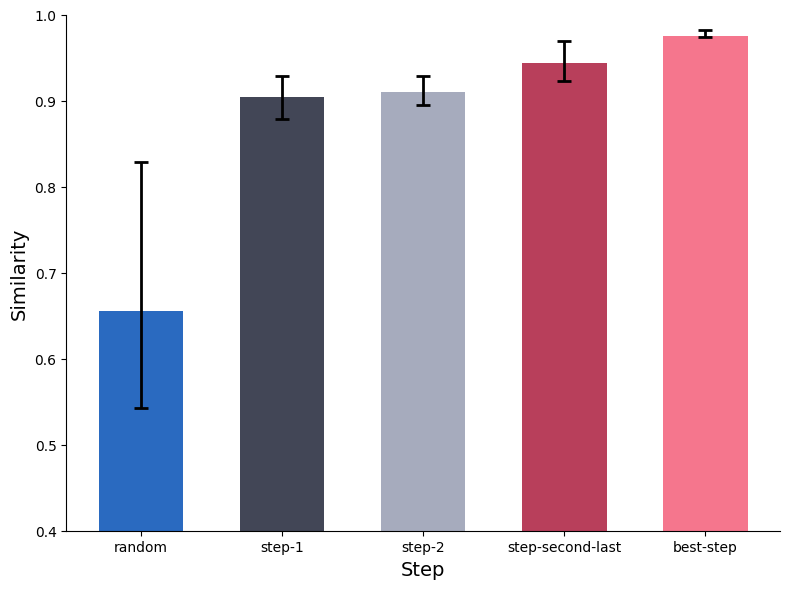

In [81]:
# colors = ['#a8f88e', '#48f0b9', '#00e2e2', '#00cffb', '#49b7fb']
colors = ['#2a6ac0', '#424656', '#a6abbd', '#b83f5b', '#f5768d']


# 去除右边和上边的边框线
fig, ax = plt.subplots(figsize=(8, 6))

# 绘制柱状图
bars = ax.bar(x_labels, means, color=colors, width=0.6)

# 绘制误差线（最小值到最大值）
ax.errorbar(x_labels, means, yerr=[np.subtract(means, mins), np.subtract(maxs, means)], fmt='none', 
            ecolor='black', capsize=5, capthick=2, elinewidth=2)

# 设置y轴范围
plt.ylim(0.4, 1)

# 去除右边和上边的边框线
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 添加标签
plt.xlabel('Step', fontsize=14)
plt.ylabel('Similarity', fontsize=14)

# 调整布局并显示图形
plt.tight_layout()
plt.show()


In [90]:
image_gt_path = image_gt_folder[5]

In [91]:
image_gt_path

'/mnt/repo0/ldy/3090/Workspace/THINGS/osfstorage/THINGS/Images/images/basketball/basketball_13s.jpg'

In [37]:
# seeds = np.random.randint(1, 100, 10)

In [93]:
# for image_gt_path in image_gt_path:
# for ii in seeds:
seed = 0  # 你可以根据需要更改随机种子
set_random_seed(seed)
max_iterations = 20
gamma = 0.9
num_images=10
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# timestamp=1

synthetic_eeg = torch.tensor(get_gteeg(image_gt_path, encoder_model_path, device))
gt_eeg_path = save_eeg(synthetic_eeg, gt_eeg_folder,file_name=f"gt_{timestamp}.npy" )
yhat = get_eeg_features(eeg_model, synthetic_eeg, device)

policy = initial_policy  # 初始随机策略
history = []  # 保存已选图片的历史记录
max_similarities = []  # 保存每次迭代中的最大相似度
historical_max_similarity = -np.inf  # 初始化历史最高相似度
min_similarities = []  # 保存每次迭代中的最小相似度
variances = []  # 保存每次迭代中相似度的方差
scores_per_iteration = []  # 保存每次迭代中每张图片的分数或概率
selected_eegs_per_iteration=[]
similarities_per_iteration = []
loooop_max_similarities = []
save_folder = f'/mnt/repo0/kyw/close-loop/results_retrival/{timestamp}'
os.makedirs(save_folder, exist_ok=True)
value_function = np.zeros(image_pool.view(-1, 1024).shape[0])  # 初始化累积的价值函数 [2400]

image_pool = image_pool.view(-1, 1024)  # 展平到 [2400, 1024]

for iteration in range(max_iterations):
    print(f"Iteration {iteration+1}...")
    
    temperature = max(1.0, 2.0 - iteration * 0.1)         

        
    # 更新历史记录，选择的图片加入历史
    best_images = policy(image_pool, history=history)
    history.extend([cat * 12 + idx for cat, idx in best_images])  # 记录平面索引
    # 输出选中的图片的实际路径，并可视化
    selected_image_paths = []
    similarities = []
    distances = []
    choose_eeg_features = []
    print(best_images)
    # 输出选中的图片的实际路径
    for cat, img in best_images:
        
        image_path = get_image_path(cat, img, text_list)
        selected_image_paths.append(image_path)
        print(f"Selected image path: {image_path}")
        
        # 计算图片与 groundtruth EEG 信号的相似度
        similarity ,choose_eeg_feature= reward_function(image_path, encoder_model_path, yhat, timestamp)
        print(similarity)
        similarities.append(similarity)
        choose_eeg_features.append(choose_eeg_feature)
    similarities_per_iteration.append(similarities)
    selected_eegs_per_iteration.append(choose_eeg_features)
    
    max_similarity = np.max(similarities)
    min_similarity = np.min(similarities)
    # variance = np.var(distances)
    # print('maxxxx')
    # print(max_similarity)
    # print(similarities)
    if max_similarity < historical_max_similarity:
        max_similarity = historical_max_similarity  # 保留之前的最高相似度
    else:
        historical_max_similarity = max_similarity  # 更新历史最高相似度
    
    max_similarities.append(max_similarity)
    min_similarities.append(min_similarity)
    
    # variances.append(variance)
    # max_similarity = np.max(similarities)
    # min_similarity = np.min(similarities)
    variance = np.var(similarities)
    
    # if max_similarity < historical_max_similarity:
    #     max_similarity = historical_max_similarity  # 保留之前的最高相似度
    # else:
    #     historical_max_similarity = max_similarity  # 更新历史最高相似度
    
    # max_similarities.append(max_similarity)
    # min_similarities.append(min_similarity)
    variances.append(variance)
        
    # 可视化选中的图片
    visualize_images(selected_image_paths, similarities, save_folder,iteration)
    # 计算相似度的均值和方差
    # 计算相似度范围

    # variances.append(variance)
    print(f"Iteration {iteration+1} max_similarity: {max_similarity}")
    # 保存每轮的图片和相似度数据
    
    save_results(save_folder, iteration+1, selected_image_paths, similarities, max_similarity)
    
    # 策略评估
    value_function= policy_evaluation(policy, image_pool, best_images, similarities,encoder_model_path, timestamp, text_list,value_function, historical_max_similarity,gamma, history=history)
    # print(policy)
    # print(similarities)
    scores_per_iteration.append(value_function)
    print(f"Scores for iteration {iteration+1}:")
    print(value_function)
    
    save_value_function_to_txt(value_function, save_folder,iteration)


    # 策略改进
    new_policy = policy_improvement(value_function, image_pool, iteration, save_folder, num_images=num_images, temperature=temperature)
        
    # 检查策略是否收敛
    if policy == new_policy:
        print("Policy converged.")
        break  # 策略收敛，停止迭代
    
    if historical_max_similarity > 0.97:
        print("Got it.")
        break  # 策略收敛，停止迭代
        
        
    policy = new_policy  # 更新策略


# plot_similarity_range(similarities_per_iteration, save_folder)
plot_similarity_and_mse_with_dual_axis(similarities_per_iteration, save_folder, target_similarity=1.0)

visualize_feature_distribution(yhat, selected_eegs_per_iteration, save_folder)
loooop_max_similarities.append(max_similarities)
save_amx_similarities(save_folder, loooop_max_similarities)


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/repo0/kyw/close-loop/results/syn_eeg_gt/gt_20241002_170131.npy'